In [1]:
import torch
from utils import *
from utils import TemperatureScheduler, calc_ce_loss, TokenizedDataset, DotDict, AutoEncoderTopK
# Example usage:
from transformers import AutoModelForCausalLM, AutoTokenizer
# model_name = "gpt2"
# model_name = "HuggingFaceTB/SmolLM-360M"
model_name = "HuggingFaceTB/SmolLM-135M"
m_name_save= model_name.replace("/", "_")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_bos_token = True
# batch_size = 512
# batch_size = 32
batch_size =32
max_length = 128
learning_rate = 1e-3

# Handle datasets, activation layers, etc. for GPT2 vs SmolLM
if(model_name == "gpt2"):
    target_layer = 'transformer.h.5'
    d_name = None
else: 
    target_layer = "model.layers.18"
    d_name = "cosmopedia-v2"
debug = True
if(debug):
    if(model_name == "gpt2"):
        dataset_name = "Elriggs/openwebtext-100k"
    else: 
        dataset_name = "HuggingFaceTB/smollm-corpus"
    # num_datapoints = 1_000_000
    # num_datapoints = 20_000
    # num_datapoints = 15_000
    num_datapoints = 2_000
    total_batches = num_datapoints // batch_size
    print(f"total amount of tokens in dataset: {num_datapoints * max_length / 1e6}M")
else:    
    if(model_name == "gpt2"):
        dataset_name = "prithivMLmods/OpenWeb888K"
        num_datapoints = 888_000 # 880_000
        total_batches = 888_000 // batch_size
    else: 
        dataset_name = "HuggingFaceTB/smollm-corpus"
        num_datapoints = 2_000_000
        total_batches = num_datapoints // batch_size
        print(f"total amount of tokens in dataset: {num_datapoints * max_length / 1e6}M")

data_generator = TokenizedDataset(dataset_name, tokenizer, d_name, batch_size=batch_size, max_length=max_length, total_batches=total_batches)

val_data_generator = TokenizedDataset(dataset_name, tokenizer, d_name, batch_size=batch_size, max_length=max_length, total_batches=total_batches, shuffle_seed=98)

total amount of tokens in dataset: 0.256M


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

# Download Pretrained SAE

In [ ]:
# Now we want to download all our SAEs
import json
from huggingface_hub import hf_hub_download
huggingface_name = "Elriggs/seq_concat_HuggingFaceTB_SmolLM-135M_model.layers.18"
name_prefix = f"sae_k=30_tokBias=True"
sae_name_style = name_prefix + ".pt"
cfg_name_style = name_prefix + "_cfg.json"

model_path = hf_hub_download(
    repo_id=huggingface_name,
    filename=sae_name_style
)

# Download config file
config_path = hf_hub_download(
    repo_id=huggingface_name,
    filename=cfg_name_style
)
cfg = DotDict(json.load(open(config_path)))

sae = AutoEncoderTopK.from_pretrained(model_path, k=cfg.k, device = None, embedding=True)
print(f"Memory usage: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

sae.to(device)
# print memory  in GB
print(f"Memory usage: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

Memory usage: 0.51 GB
Memory usage: 0.65 GB


# SGLD
Train the LLM, alternating SGD steps & adding noise (ie temperature) to the weights. 
Code & paper from: https://github.com/bfpill/devinterp-1/blob/main/modular_addition/calc_lambda.ipynb
use an elasticity loss (ie difference from original weights) & various scaling terms, which we do not need here.

We've simplified for our case as simply:
weight_update = lr\*gradient + temp\*noise

So scaling the temperature increases the noise, which increases the overall CE loss.

In [3]:
import os

def update_feature_sim(feature_sim, per_feature_MSE, local_ids, num_features, batch_idx):
    # find out how many times each feature index shows up in local_ids
    num_features = post_relu_feat_acts_BF.shape[-1]
    # Get unique indices and their counts
    unique_indices, counts = torch.unique(local_ids, return_counts=True)

    unique_counts = torch.zeros(num_features, device=local_ids.device)
    unique_counts.index_put_((unique_indices,), counts.float())

    feature_mse_sum = torch.zeros(num_features, device=local_ids.device)
    feature_mse_sum.scatter_add_(0, local_ids.flatten(), per_feature_MSE.flatten())

    # Compute the average MSE for each feature by dividing by its count
    # (avoiding division by zero for features that don't appear)
    feature_mask = unique_counts > 0
    feature_mse_avg = torch.zeros_like(feature_mse_sum)
    feature_mse_avg[feature_mask] = feature_mse_sum[feature_mask] / unique_counts[feature_mask]

    feature_sim[batch_idx, unique_indices] = feature_mse_avg[unique_indices].to("cpu")
    return feature_sim

def sub_bias_and_normalize(x, sae, batch, normalize=True):
    if normalize:
        x = (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + 1e-8)
    if sae.per_token_bias:
        x = x - sae.per_token_bias(batch)
    return x

import math
# lots of code used from https://github.com/bfpill/devinterp-1/blob/main/modular_addition/calc_lambda.ipynb
# feature_sim = torch.ones(total_batches, 9216)*-0.1 # num of features
num_features = sae.encoder.weight.shape[0]
dataset_size = num_datapoints* max_length
lr = 1e-4  # "epsilon"
normalize = True
#temp 5.0e-4 went t. 2.0 & never recovered (also gamm=10)
# Temperature parameters
# max_temp = 2.0e-4
max_temp = 8.0e-5
lowest_temp = 0.0
peak_noise_fraction = 0.001
start_decreasing_fraction = 0.8
stay_at_zero_fraction = 0.9
tempScheduler = TemperatureScheduler(
    max_temp,
    lowest_temp,
    peak_noise_fraction,
    start_decreasing_fraction,
    stay_at_zero_fraction
)
# save_checkpoints_every = 10
# batches_to_run = 10 #for validation
save_checkpoints_every = 50
batches_to_run = 20 #for validation


from copy import deepcopy
orig_model = deepcopy(model)
orig_sae = deepcopy(sae)
all_ce_losses = []
# all_elasticity_losses = []
all_ce_diffs = []
fvus = []
# Optimizers
# For the LLM, we start w/ SGD when adding noise (for SLGD), then switch to Adam for "recovering" since that converges better.
sgd_opt = torch.optim.SGD(model.parameters(), lr=1.0)
adam_opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
sae_opt = torch.optim.Adam(sae.parameters(), lr=learning_rate)
restarted_adam=False
for batch_idx in tqdm(range(total_batches)):

    current_opt = adam_opt if tempScheduler.current_state == "low_temp" else sgd_opt
    current_opt.zero_grad() 
    sae_opt.zero_grad()

    if(cfg.norm_decoder):
        sae.set_decoder_norm_to_unit_norm()
    
    # LLM CE loss (and grab intermediate activation for SAE)
    batch = data_generator.next().to(device)
    with Trace(model, target_layer) as original_trace:
        ce_loss = model(batch, labels=batch).loss
        new_x = original_trace.output[0] if isinstance(original_trace.output, tuple) else original_trace.output
        new_x = new_x.detach()

    full_loss = lr/2 *ce_loss
    full_loss.backward()
    current_opt.step()

    # Check if we need to switch to Adam for "recovering"
    if(tempScheduler.current_state == "low_temp" and not restarted_adam):
        # Restart Adam optimizer
        # Note: I haven't checked if you 
        print("Restarting Adam optimizer")
        # for state in adam_opt.state.values():
        #     state.clear()
        adam_opt = torch.optim.Adam(model.parameters(), lr=1e-5)
        restarted_adam = True

    # SAE
    normalized_new_x = (new_x - new_x.mean(dim=-1, keepdim=True)) / (new_x.std(dim=-1, keepdim=True) + 1e-8)
    bias = sae.per_token_bias(batch)
    x_hat = sae(normalized_new_x - bias) + bias
    with torch.no_grad():
        fvu = calculate_fvu(normalized_new_x, x_hat)
    mse = torch.mean((x_hat - normalized_new_x) ** 2)
    mse.backward()
    if(cfg.norm_decoder):
        sae.remove_gradient_parallel_to_decoder_directions()

    sae_opt.step()

    # Add noise to the parameters
    with torch.no_grad():
        if tempScheduler.current_state != "low_temp":
            temperature = tempScheduler.get_temperature(batch_idx, total_batches)
            new_params = torch.nn.utils.parameters_to_vector(model.parameters()) 
            noise = torch.randn_like(new_params) * temperature
            torch.nn.utils.vector_to_parameters(new_params + noise, model.parameters())


    store_data_every = 5
    print_every = 25    
    if batch_idx % store_data_every == 0:
        all_ce_losses.append(ce_loss.item())
        with torch.no_grad():
            # Get original model's acts & SAE features
            original_ce_loss = orig_model(batch, labels=batch).loss
            ce_diff = ce_loss - original_ce_loss
        all_ce_diffs.append(ce_diff.item())
        fvus.append(fvu.item())
    if batch_idx % print_every == 0:
        print(f"Batch {batch_idx}/{total_batches}, CE diff: {ce_diff.item():.3f}, fvu: {fvu:.3f} | temperature: {temperature:.1e}")

    #TODO don't forget to flip this later
    store_acts=True
    if(store_acts):
        with torch.no_grad():
            # save first batch info:
            d_model = model.config.hidden_size
            os.makedirs("checkpoints", exist_ok=True)
            # First batch, store the original mdoel's tokens, activations, and CE loss
            if batch_idx == 0:
                # Note: we skip the first token for all activations, tokens to match up w/ CE loss's shape.
                all_tokens = torch.zeros(batches_to_run*batch_size, max_length-1, dtype=torch.long)
                val_original_ce_loss = torch.zeros(batches_to_run*batch_size, max_length-1, dtype=torch.float16)
                all_activations = torch.zeros(batches_to_run*batch_size, max_length-1, d_model, dtype=torch.float16)
                val_data_generator.reset_iterator()
                for i in range(batches_to_run):
                    batch = val_data_generator.next().to(device)
                    with Trace(orig_model, target_layer) as original_trace:
                        original_logits = orig_model(batch, labels=batch, reduction="none").logits
                        original_x = original_trace.output[0] if isinstance(original_trace.output, tuple) else original_trace.output
                        original_x = original_x.detach()
                    ce_loss = calc_ce_loss(original_logits, batch)

                    val_original_ce_loss[i*batch_size:(i+1)*batch_size] = ce_loss.cpu() # already max_len - 1
                    all_activations[i*batch_size:(i+1)*batch_size] = original_x[:, 1:].cpu()
                    all_tokens[i*batch_size:(i+1)*batch_size] = batch[:, 1:].cpu()
                torch.save({
                    "ce_loss": val_original_ce_loss,
                    "all_activations": all_activations,
                    "all_tokens": all_tokens,
                }, f"checkpoints/first_batch_info_skip_first_token.pt")
                # DELETE all tokens
                del all_tokens
                del all_activations
                del val_original_ce_loss
                del original_logits
                del original_trace
                import gc
                gc.collect()
                # clear cache
                torch.cuda.empty_cache()
                
            # Else, we are saving every N checkpoints
            elif (batch_idx) % save_checkpoints_every == 0:
                # if we shoot for 1m tokens then,
                # batches_to_run = 1_000_000 // (batch_size*max_length)
                num_features = orig_sae.encoder.out_features

                # For reasons, we store both original feature acts & new feature acts, even though we could've cached the original SAE features.
                original_feature_acts = torch.zeros(batches_to_run*batch_size, max_length-1, num_features, dtype=torch.float16)
                new_feature_acts = torch.zeros(batches_to_run*batch_size, max_length-1, num_features, dtype=torch.float16)
                val_new_ce_loss = torch.zeros(batches_to_run*batch_size, max_length-1, dtype=torch.float16)
                all_activations = torch.zeros(batches_to_run*batch_size, max_length-1, d_model, dtype=torch.float16)

                print("Saving feature activations")
                for i in tqdm(range(batches_to_run),  total=batches_to_run):
                    batch = val_data_generator.next().to(device)
                    with Trace(model, target_layer) as original_trace:
                        logits = model(batch, labels=batch).logits
                        new_x = original_trace.output[0] if isinstance(original_trace.output, tuple) else original_trace.output
                        new_x = new_x.detach()
                    new_ce_loss = calc_ce_loss(logits, batch)

                    with Trace(orig_model, target_layer) as original_trace:
                        # We could just get the SAE features in first batch, BUT we do need the local_ids of original-SAE for the new one
                        _ = orig_model(batch, labels=batch) # Original CE calculated in first batch
                        old_x = original_trace.output[0] if isinstance(original_trace.output, tuple) else original_trace.output
                        old_x = old_x.detach()

                    # x = x.normalize - bias (so ready for SAE.encode)
                    old_x = sub_bias_and_normalize(old_x, orig_sae, batch, normalize=normalize)
                    new_normalized_x = sub_bias_and_normalize(new_x, sae, batch, normalize=normalize)

                    original_features, local_mags, local_ids = orig_sae.encode(old_x, return_topk=True)

                    post_relu_feat_acts_BF = nn.functional.relu(sae.encoder(new_normalized_x - sae.b_dec))
                    # get the activations at the feature_ids (feature_ids is = to top_indices_BK)
                    custom_feature_acts = post_relu_feat_acts_BF.gather(dim=-1, index=local_ids)
                    buffer_BF = torch.zeros_like(post_relu_feat_acts_BF)
                    custom_features = buffer_BF.scatter_(dim=-1, index=local_ids, src=custom_feature_acts)

                    # feature_sim = update_feature_sim(feature_sim, per_feature_MSE, local_ids, num_features = post_relu_feat_acts_BF.shape[-1], batch_idx=batch_idx)
                    start_idx = i*(batch_size)
                    end_idx = start_idx + (batch_size)  
                    # Let's ignore the first token for all features in general
                    val_new_ce_loss[start_idx:end_idx] = new_ce_loss # first token ignored by default
                    original_feature_acts[start_idx:end_idx] = original_features[:, 1:].cpu() 
                    new_feature_acts[start_idx:end_idx] = custom_features[:, 1:].cpu()
                    all_activations[start_idx:end_idx] = new_x[:, 1:].cpu()

                # save the feature_sim, original_feature_acts, new_feature_acts
                # make  dir if not exists
                torch.save({
                    # "feature_sim": feature_sim,
                    "ce_loss": val_new_ce_loss,
                    "all_activations": all_activations,
                    "original_feature_acts": original_feature_acts,
                    "new_feature_acts": new_feature_acts}, f"checkpoints/feature_sim_{batch_idx}.pt")

  0%|          | 0/62 [00:00<?, ?it/s]

Batch 0/62, CE diff: 0.000, fvu: 0.117 | temperature: 0.0e+00


 42%|████▏     | 26/62 [00:28<00:25,  1.39it/s]

Batch 25/62, CE diff: -0.001, fvu: 0.113 | temperature: 8.0e-05


 81%|████████  | 50/62 [00:44<00:07,  1.55it/s]

Batch 50/62, CE diff: -0.002, fvu: 0.114 | temperature: 7.5e-05
Saving feature activations


 94%|█████████▎| 58/62 [01:11<00:04,  1.23s/it]

Restarting Adam optimizer


100%|██████████| 62/62 [01:14<00:00,  1.20s/it]


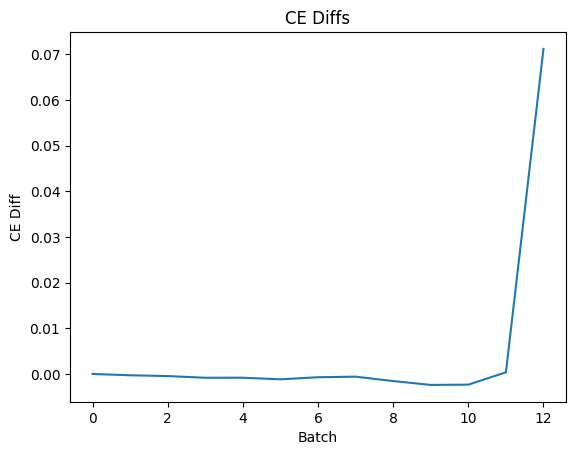

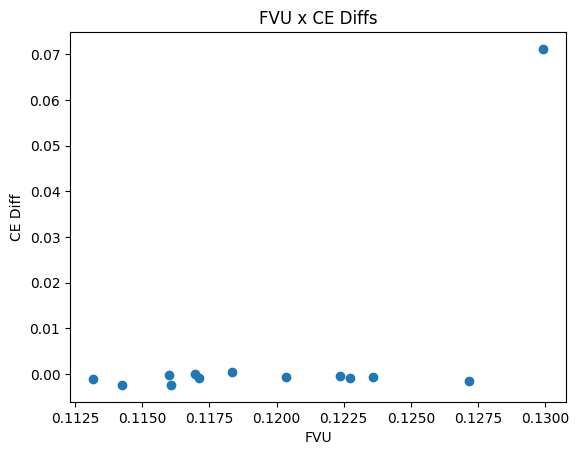

In [7]:
# We basically want to plot the CE-diff over the batches
import matplotlib.pyplot as plt
# fvus, all_ce_diffs, ce_loss
plt.plot(all_ce_diffs)
plt.ylabel("CE Diff")
plt.xlabel("Batch")
plt.title("CE Diffs")
plt.show()

plt.scatter(fvus, all_ce_diffs)
plt.ylabel("CE Diff")
plt.xlabel("FVU")
plt.title("FVU x CE Diffs")
plt.show()
